<a href="https://colab.research.google.com/github/shreekar2005/Cheminformatics_DC/blob/main/DC2_NN_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import cudf
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, classification_report, roc_auc_score
from tabulate import tabulate
import pandas as pd
from scipy import io

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load Data using Pandas
y_tr = pd.read_csv('drive/MyDrive/DATASET/tox21_labels_train.csv.gz', index_col=0, compression="gzip")
y_te = pd.read_csv('drive/MyDrive/DATASET/tox21_labels_test.csv.gz', index_col=0, compression="gzip")
x_tr_dense = pd.read_csv('drive/MyDrive/DATASET/tox21_dense_train.csv.gz', index_col=0, compression="gzip").values
x_te_dense = pd.read_csv('drive/MyDrive/DATASET/tox21_dense_test.csv.gz', index_col=0, compression="gzip").values
x_tr_sparse = io.mmread('drive/MyDrive/DATASET/tox21_sparse_train.mtx.gz').tocsc()
x_te_sparse = io.mmread('drive/MyDrive/DATASET/tox21_sparse_test.mtx.gz').tocsc()

# Filter out very sparse features
sparse_col_idx = ((x_tr_sparse > 0).mean(0) > 0.05).A.ravel()
x_tr = np.hstack([x_tr_dense, x_tr_sparse[:, sparse_col_idx].toarray()])
x_te = np.hstack([x_te_dense, x_te_sparse[:, sparse_col_idx].toarray()])

# Standardize features
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)
x_te = scaler.transform(x_te)

# Fill missing values in labels
target_labels = ['NR.AhR', 'NR.AR', 'NR.AR.LBD', 'NR.Aromatase', 'NR.ER', 'NR.ER.LBD',
                 'NR.PPAR.gamma', 'SR.ARE', 'SR.ATAD5', 'SR.HSE', 'SR.MMP', 'SR.p53']
y_tr[target_labels] = y_tr[target_labels].fillna(0).clip(0, 1)
y_te[target_labels] = y_te[target_labels].fillna(0).clip(0, 1)

# Convert to PyTorch tensors on CPU
device = torch.device("cpu")
X_train_torch = torch.tensor(x_tr, dtype=torch.float32)
X_test_torch = torch.tensor(x_te, dtype=torch.float32)
y_train_torch = torch.tensor(y_tr[target_labels].values, dtype=torch.float32)
y_test_torch = torch.tensor(y_te[target_labels].values, dtype=torch.float32)

print("X_train_torch.shape =", X_train_torch.shape)
print("y_train_torch.shape =", y_train_torch.shape)
print("X_test_torch.shape =", X_test_torch.shape)
print("y_test_torch.shape =", y_test_torch.shape)

X_train_torch.shape = torch.Size([12060, 1644])
y_train_torch.shape = torch.Size([12060, 12])
X_test_torch.shape = torch.Size([647, 1644])
y_test_torch.shape = torch.Size([647, 12])


In [9]:
print(X_train_torch.shape)
print(y_train_torch.shape)
print(X_test_torch.shape)
print(y_test_torch.shape)
# print(y_test_torch[3])

# Number of new samples
num_new_samples = 5000

# Get the number of existing samples
num_samples = X_train_torch.shape[0]

# Randomly select indices for triplets
idx1 = torch.randint(0, num_samples, (num_new_samples,))
idx2 = torch.randint(0, num_samples, (num_new_samples,))
idx3 = torch.randint(0, num_samples, (num_new_samples,))

# Compute new X by averaging features
X_new = (X_train_torch[idx1] + X_train_torch[idx2] + X_train_torch[idx3]) / 3.0

# Convert y to boolean before OR operation
y_new = (y_train_torch[idx1].bool() | y_train_torch[idx2].bool() | y_train_torch[idx3].bool()).float()

# Concatenate with the original dataset
X_train_torch_new = torch.cat([X_train_torch, X_new], dim=0)
y_train_torch_new = torch.cat([y_train_torch, y_new], dim=0)

# Print new shapes
print(X_train_torch_new.shape)
print(y_train_torch_new.shape)

# Create PyTorch DataLoader
def create_dataloader(X, y, batch_size=64, shuffle=True):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_train_torch, y_train_torch)
test_loader = create_dataloader(X_test_torch, y_test_torch, batch_size=32, shuffle=False)


torch.Size([12060, 1644])
torch.Size([12060, 12])
torch.Size([647, 1644])
torch.Size([647, 12])
torch.Size([17060, 1644])
torch.Size([17060, 12])


In [24]:
# Define Flexible Neural Network Class
class FlexibleNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers=[512, 256], dropout_rate=0.2):
        super(FlexibleNN, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())  # Multi-label classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [25]:
# Model initialization with flexibility
input_size = x_tr.shape[1]
output_size = y_tr.shape[1]

hidden_layers = [1024, 512, 256, 512, 256]  # Increased neurons to improve TPR
dropout_rate = 0.1  # Reduced dropout rate to retain more features

model = FlexibleNN(input_size, output_size, hidden_layers, dropout_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FlexibleNN(
  (model): Sequential(
    (0): Linear(in_features=1644, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=256, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=512, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True,

In [26]:

# Custom Weighted BCE Loss to Reduce False Negatives
class CustomBCELoss(nn.Module):
    def __init__(self, pos_weight=2.0):  # Increase weight for positives
        super(CustomBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

    def forward(self, outputs, targets):
        loss = self.bce(outputs, targets)
        return loss

# Define loss with higher positive weight
criterion = CustomBCELoss(pos_weight=10.0)  # Increase this if FN still exists
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    epoch_losses = []  # Store loss values for plotting
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Plot loss vs epochs
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs. Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/50, Loss: 0.9892
Epoch 2/50, Loss: 0.9593
Epoch 3/50, Loss: 0.9531
Epoch 4/50, Loss: 0.9500
Epoch 5/50, Loss: 0.9459
Epoch 6/50, Loss: 0.9441
Epoch 7/50, Loss: 0.9391
Epoch 8/50, Loss: 0.9383
Epoch 9/50, Loss: 0.9352
Epoch 10/50, Loss: 0.9339
Epoch 11/50, Loss: 0.9309
Epoch 12/50, Loss: 0.9291
Epoch 13/50, Loss: 0.9274
Epoch 14/50, Loss: 0.9239
Epoch 15/50, Loss: 0.9243
Epoch 16/50, Loss: 0.9227
Epoch 17/50, Loss: 0.9212
Epoch 18/50, Loss: 0.9214
Epoch 19/50, Loss: 0.9172
Epoch 20/50, Loss: 0.9162
Epoch 21/50, Loss: 0.9157
Epoch 22/50, Loss: 0.9142
Epoch 23/50, Loss: 0.9142
Epoch 24/50, Loss: 0.9123
Epoch 25/50, Loss: 0.9125
Epoch 26/50, Loss: 0.9094
Epoch 27/50, Loss: 0.9102
Epoch 28/50, Loss: 0.9099
Epoch 29/50, Loss: 0.9080
Epoch 30/50, Loss: 0.9079
Epoch 31/50, Loss: 0.9069
Epoch 32/50, Loss: 0.9061
Epoch 33/50, Loss: 0.9053
Epoch 34/50, Loss: 0.9049
Epoch 35/50, Loss: 0.9035
Epoch 36/50, Loss: 0.9030
Epoch 37/50, Loss: 0.9036
Epoch 38/50, Loss: 0.9026
Epoch 39/50, Loss: 0.

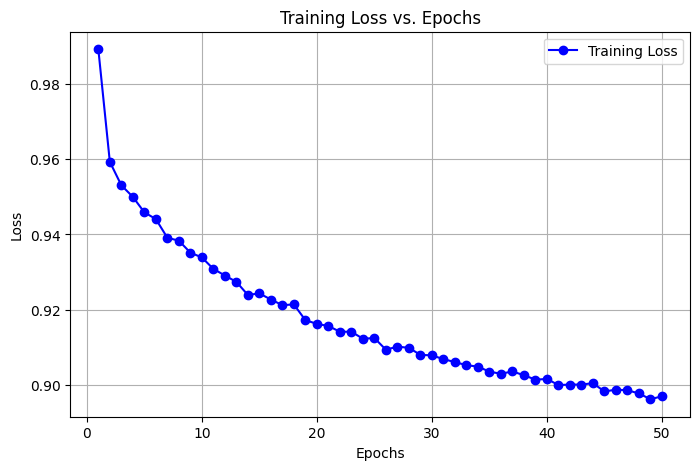

In [27]:
# Training
train_model(model, train_loader, criterion, optimizer, epochs=50)

In [28]:
# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu().numpy()
            all_preds.append(outputs)
            all_labels.append(y_batch.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

# Get predictions from the model
preds, labels = evaluate_model(model, test_loader, device)

# Apply threshold
threshold = 0.5
preds = (preds > threshold).astype(int)

# Initialize result containers
results_table = []
macro_precisions, macro_recalls, macro_f1s = [], [], []
weighted_precisions, weighted_recalls, weighted_f1s = [], [], []
total_support = 0

print("\n" + "-"*60)
print("Final Classification Report for Selected Assays (Class 1 only):")
print("-"*60)

# Loop over each assay
for i, label in enumerate(target_labels):
    true_labels = labels[:, i]
    preds_label = preds[:, i]

    # if np.sum(true_labels) == 0 or np.sum(preds_label) == 0:
    #     continue

    report = classification_report(true_labels, preds_label, output_dict=True)
    tn, fp, fn, tp = confusion_matrix(true_labels, preds_label).ravel()
    auc = roc_auc_score(true_labels, preds_label)

    support_1 = fn + tp
    support_total = tn + fp + fn + tp

    precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0.0

    results_table.append([
        f"Assay {i+1}: {label}", f"{precision_1:.4f}", f"{recall_1:.4f}", f"{f1_1:.4f}",
        support_total, f"{tn}", f"{fp}", f"{fn}", f"{tp}", f"{auc:.5f}"
    ])

    macro_precisions.append(precision_1)
    macro_recalls.append(recall_1)
    macro_f1s.append(f1_1)

    weighted_precisions.append(precision_1 * support_1)
    weighted_recalls.append(recall_1 * support_1)
    weighted_f1s.append(f1_1 * support_1)
    total_support += support_1

# Print detailed table
headers = ["Assay", "Precision", "Recall", "F1-Score", "Support", "TN", "FP", "FN", "TP", "AUC"]
print(tabulate(results_table, headers=headers, tablefmt="fancy_grid"))

# Print summary averages
summary_table = [[
    "Macro Avg", f"{np.mean(macro_precisions):.6f}", f"{np.mean(macro_recalls):.6f}",
    f"{np.mean(macro_f1s):.6f}"
], [
    "Weighted Avg", f"{np.sum(weighted_precisions)/total_support:.6f}",
    f"{np.sum(weighted_recalls)/total_support:.6f}",
    f"{np.sum(weighted_f1s)/total_support:.6f}"
]]
print("\n" + tabulate(summary_table, headers=["Metric", "Precision", "Recall", "F1-Score"], tablefmt="fancy_grid"))


------------------------------------------------------------
Final Classification Report for Selected Assays (Class 1 only):
------------------------------------------------------------
╒════════════════════════╤═════════════╤══════════╤════════════╤═══════════╤══════╤══════╤══════╤══════╤═════════╕
│ Assay                  │   Precision │   Recall │   F1-Score │   Support │   TN │   FP │   FN │   TP │     AUC │
╞════════════════════════╪═════════════╪══════════╪════════════╪═══════════╪══════╪══════╪══════╪══════╪═════════╡
│ Assay 1: NR.AhR        │      0.4433 │   0.589  │     0.5059 │       647 │  520 │   54 │   30 │   43 │ 0.74748 │
├────────────────────────┼─────────────┼──────────┼────────────┼───────────┼──────┼──────┼──────┼──────┼─────────┤
│ Assay 2: NR.AR         │      0.4    │   0.1667 │     0.2353 │       647 │  632 │    3 │   10 │    2 │ 0.58097 │
├────────────────────────┼─────────────┼──────────┼────────────┼───────────┼──────┼──────┼──────┼──────┼─────────┤
│ Assay 